In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from keras.utils import np_utils
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from keras.applications.vgg16 import VGG16

In [4]:
from keras.applications.vgg19 import VGG19

In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:
# Constants
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 10
batch_size = 64


In [7]:
# Get ResNet-50 Model
def getResNet50Model(lastFourTrainable=False):
    resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
    # Make all layers non-trainable
    for layer in resnet_model.layers[:]:
        layer.trainable = False
    # Add fully connected layer which have 1024 neuron to ResNet-50 model
    output = resnet_model.get_layer('avg_pool').output
    output = Flatten(name='new_flatten')(output)
    output = Dense(units=1024, activation='relu', name='new_fc')(output)
    predictions = Dense(units=50, activation='softmax')(output)
    resnet_model = Model(resnet_model.input, predictions)
    # Make last 4 layers trainable if lastFourTrainable == True
    if lastFourTrainable == True:
        resnet_model.get_layer('conv5_block3_2_bn').trainable = True
        resnet_model.get_layer('conv5_block3_3_conv').trainable = True
        resnet_model.get_layer('conv5_block3_3_bn').trainable = True
        resnet_model.get_layer('new_fc').trainable = True
    # Compile ResNet-50 model
    resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    resnet_model.summary()
    return resnet_model

In [8]:
traindf = pd.read_csv("../input/landmark-recognition-2021/train.csv")
traindf.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [9]:
traindf.shape

(1580470, 2)

In [10]:
landmark_unique = traindf['landmark_id'].unique()
len(landmark_unique)

81313

In [11]:
landmark_unique[0:50]

array([  1,   7,   9,  11,  12,  17,  22,  23,  24,  27,  29,  30,  32,
        34,  36,  37,  41,  43,  48,  50,  51,  56,  58,  60,  63,  65,
        66,  72,  79,  81,  82,  83,  84,  87,  89,  90,  99, 100, 101,
       103, 104, 110, 111, 115, 117, 118, 123, 124, 131, 134])

In [12]:
image_ids = []
labels = []
temp_labels = []
i=0
for id_ in landmark_unique[0:50]:
    for iid in traindf['id'][traindf['landmark_id'] == id_]:
        image_ids.append(iid)
        labels.append(id_)
        temp_labels.append(i)
    i = i+1
len(image_ids)

1144

In [13]:
mainpath = '../input/landmark-recognition-2021/train'
image_path = []
images_pixels = []

for i in range(0,len(image_ids)):
    first_dir = os.path.join(mainpath,image_ids[i][0])
    second_dir = os.path.join(first_dir,image_ids[i][1])
    third_dir = os.path.join(second_dir,image_ids[i][2])
    finalpath = os.path.join(third_dir,image_ids[i]+'.jpg')
    
    img_pix = cv2.imread(finalpath,1)
    images_pixels.append(cv2.resize(img_pix, (224,224)))
    
    image_path.append(finalpath)

In [14]:
print('Images: ', len(image_path))
print('Image labels: ', len(labels))

Images:  1144
Image labels:  1144


In [15]:
print(temp_labels)

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

In [16]:
import random

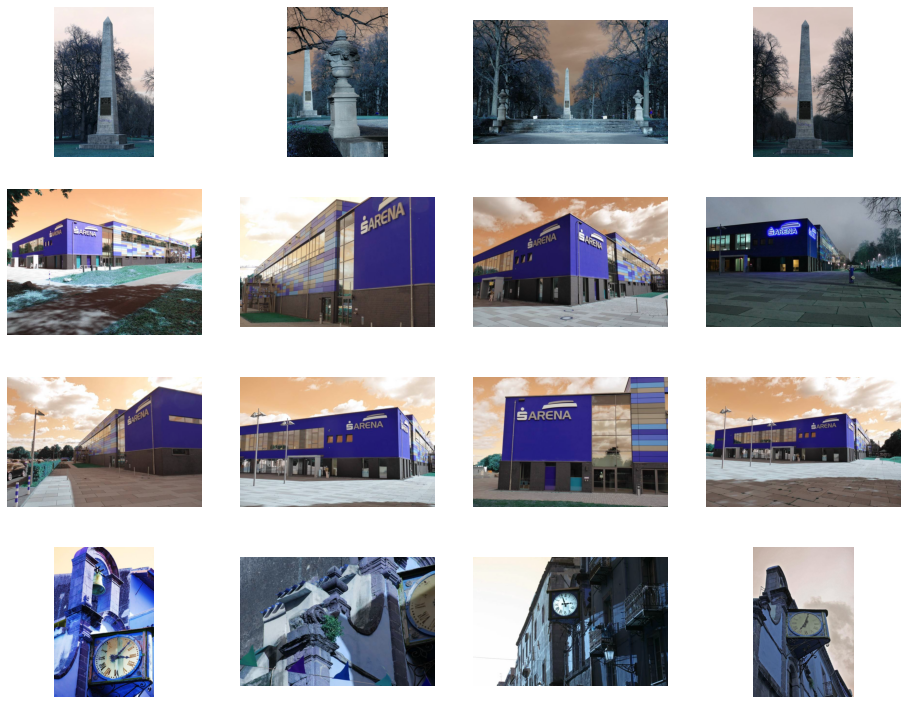

In [17]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix_ = image_path

for i, img_path in enumerate(next_pix_[0:16]):
    
    sp = plt.subplot(5, 4, i + 1)
    sp.axis('Off')

    img = cv2.imread(img_path)
    plt.imshow(img)

plt.show()

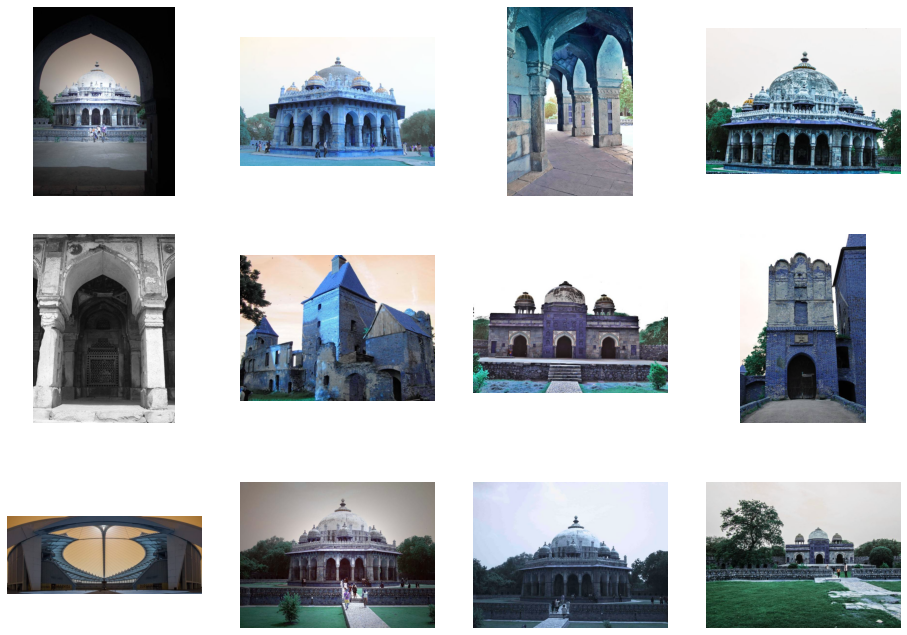

In [18]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = image_path
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = cv2.imread(img_path)
    plt.imshow(img)

plt.show()

In [19]:
shuf = list(zip(images_pixels,temp_labels))
random.shuffle(shuf)

train_data, labels_data = zip(*shuf)
print('Images: ', len(train_data))
print('Image labels: ', len(labels_data))

Images:  1144
Image labels:  1144


In [20]:
print(labels_data)

(43, 10, 36, 37, 9, 10, 35, 1, 9, 29, 21, 9, 18, 9, 9, 9, 4, 9, 43, 9, 7, 9, 26, 9, 9, 17, 23, 23, 9, 18, 9, 22, 46, 9, 3, 9, 46, 31, 6, 12, 29, 43, 3, 13, 44, 9, 17, 9, 9, 9, 9, 17, 9, 33, 9, 46, 9, 17, 17, 29, 9, 9, 9, 8, 25, 47, 9, 2, 9, 9, 7, 28, 3, 22, 9, 9, 4, 9, 15, 6, 9, 9, 9, 49, 9, 28, 9, 9, 9, 44, 9, 6, 9, 17, 17, 9, 9, 17, 49, 9, 9, 2, 19, 27, 9, 9, 9, 43, 4, 7, 9, 17, 15, 9, 9, 6, 15, 9, 9, 13, 23, 6, 15, 9, 43, 47, 16, 43, 6, 47, 36, 39, 9, 9, 9, 9, 24, 43, 9, 9, 44, 9, 31, 12, 9, 11, 9, 9, 9, 27, 9, 9, 9, 29, 4, 36, 9, 6, 9, 40, 3, 7, 9, 9, 38, 9, 9, 36, 9, 9, 47, 22, 5, 9, 35, 2, 9, 40, 9, 9, 9, 25, 9, 6, 9, 46, 35, 9, 21, 3, 9, 36, 9, 3, 9, 9, 37, 9, 42, 36, 19, 47, 9, 23, 17, 9, 12, 24, 43, 23, 33, 9, 4, 44, 7, 1, 9, 6, 9, 9, 9, 26, 49, 37, 47, 36, 32, 45, 43, 0, 47, 9, 9, 19, 9, 9, 25, 9, 15, 9, 17, 28, 9, 17, 9, 9, 47, 15, 9, 26, 43, 37, 9, 9, 1, 19, 9, 22, 26, 9, 22, 9, 17, 8, 9, 9, 9, 9, 9, 32, 17, 47, 4, 9, 19, 9, 9, 44, 34, 36, 19, 35, 2, 9, 9, 16, 26, 43, 11, 9

In [21]:
'''# Function for plotting the Confusion Matrix
def plotConfusionMatrix(cm, class_names, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    '''

'# Function for plotting the Confusion Matrix\ndef plotConfusionMatrix(cm, class_names, normalize=True, title=\'Confusion matrix\', cmap=plt.cm.Blues):\n    plt.figure(figsize=(10,10))\n    plt.imshow(cm, interpolation=\'nearest\', cmap=cmap)\n    plt.title(title)\n    plt.colorbar()\n    tick_marks = np.arange(len(class_names))\n    plt.xticks(tick_marks, class_names, rotation=45)\n    plt.yticks(tick_marks, class_names)\n    if normalize:\n        cm = cm.astype(\'float\') / cm.sum(axis=1)[:, np.newaxis]\n        cm = np.around(cm, decimals=2)\n        cm[np.isnan(cm)] = 0.0\n        print("Normalized confusion matrix")\n    else:\n        print(\'Confusion matrix, without normalization\')\n\n    thresh = cm.max() / 2.\n    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):\n        plt.text(j, i, cm[i, j],\n                horizontalalignment="center",\n                color="white" if cm[i, j] > thresh else "black")\n\n    plt.tight_layout()\n    plt.ylabel(\'Tr

In [22]:
"""
# Function for train the given model and get Confusion Matrix
def trainModelAndGetConfusionMatrix(model,train_generator,valid_generator,test_generator,epochs,batch_size):
    # Fit the model
    model.fit_generator(train_generator,
                      epochs=epochs,
                      steps_per_epoch=len(train_generator) // batch_size,
                      validation_data=valid_generator,
                      validation_steps=len(valid_generator) // batch_size)
    # Evaluate the model
    loss_and_metrics = model.evaluate_generator(test_generator, steps=len(test_generator) // batch_size+1)
    print("Test Loss: ", loss_and_metrics[0])
    print("Test Accuracy: ", loss_and_metrics[1])
    test_generator.reset()
    # Get Confusion Matrix and plot it
    Y_pred = model.predict_generator(test_generator, steps=len(test_generator) // batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    class_names = []
    for key in train_generator.class_indices:
        class_names.append(key)
    cr = classification_report(test_generator.classes, y_pred, target_names=class_names)
    print("Classification Report\n" + cr) # Print classification report
    cm = confusion_matrix(test_generator.classes, y_pred)
    plotConfusionMatrix(cm, class_names, normalize=False, title='Confusion Matrix')
    plotConfusionMatrix(cm, class_names, normalize=True, title='Confusion Matrix')
    return model
"""

'\n# Function for train the given model and get Confusion Matrix\ndef trainModelAndGetConfusionMatrix(model,train_generator,valid_generator,test_generator,epochs,batch_size):\n    # Fit the model\n    model.fit_generator(train_generator,\n                      epochs=epochs,\n                      steps_per_epoch=len(train_generator) // batch_size,\n                      validation_data=valid_generator,\n                      validation_steps=len(valid_generator) // batch_size)\n    # Evaluate the model\n    loss_and_metrics = model.evaluate_generator(test_generator, steps=len(test_generator) // batch_size+1)\n    print("Test Loss: ", loss_and_metrics[0])\n    print("Test Accuracy: ", loss_and_metrics[1])\n    test_generator.reset()\n    # Get Confusion Matrix and plot it\n    Y_pred = model.predict_generator(test_generator, steps=len(test_generator) // batch_size+1)\n    y_pred = np.argmax(Y_pred, axis=1)\n    class_names = []\n    for key in train_generator.class_indices:\n        cl

In [23]:
train_data = np.array(train_data) #/ 255


In [24]:
a = np.array(labels_data)
a_pd = pd.get_dummies(a).astype('float32').values 

In [25]:
print(labels_data[0:6])

(43, 10, 36, 37, 9, 10)


In [26]:
print(a_pd)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [27]:
labels_data=a_pd

In [28]:
print(labels_data[0:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


In [29]:
labels_data.shape

(1144, 50)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(train_data, labels_data, test_size = 0.3, random_state=101)

print("X train data : ", len(X_train))
print("X label data : ", len(X_test))
print("Y test data : ", len(Y_train))
print("Y label data : ", len(Y_test))

X train data :  800
X label data :  344
Y test data :  800
Y label data :  344


In [31]:
num_sample=X_train.shape[0]
#20% of the enteries has to be in validation set
validation_freq=int(num_sample*0.2)
#Generating random sample of indices equal to validation_freq
validationlist = random.sample(range(0, num_sample), validation_freq)
traininglist=list(set(range(0,num_sample))-set(validationlist))
print("No interesection between validationlist and traininglist:",set(traininglist).intersection(validationlist))

No interesection between validationlist and traininglist: set()


In [32]:
train_x_final=[]
train_y_final=[]
for val in traininglist:
    train_x_final.append(X_train[val])
    train_y_final.append(Y_train[val])
train_x_final=np.array(train_x_final)
train_y_final=np.array(train_y_final)
print("Training data shape",train_x_final.shape)
print("Training label shape",train_y_final.shape)

Training data shape (640, 224, 224, 3)
Training label shape (640, 50)


In [33]:
validation_x_final=[]
validation_y_final=[]
for val in validationlist:
    validation_x_final.append(X_train[val])
    validation_y_final.append(Y_train[val])
validation_x_final=np.array(validation_x_final)
validation_y_final=np.array(validation_y_final)
print("Validation data shape",validation_x_final.shape)
print("Validation label shape",validation_y_final.shape)

Validation data shape (160, 224, 224, 3)
Validation label shape (160, 50)


In [34]:
# plot the training results
def plot_hist(history,title):
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(str(title)+' accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(str(title)+' loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [35]:
# Get VGG-16 Model
def getVGG16Model(lastFourTrainable=False):
    vgg_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=True)
    # Make all layers untrainable
    for layer in vgg_model.layers[:]:
        layer.trainable = False
    # Add fully connected layer which have 1024 neuron to VGG-16 model
    output = vgg_model.get_layer('fc2').output
    output = Flatten(name='new_flatten')(output)
    output = Dense(units=1024, activation='relu', name='new_fc')(output)
    output = Dense(units=50, activation='softmax')(output)
    vgg_model = Model(vgg_model.input, output)
    # Make last 4 layers trainable if lastFourTrainable == True
    if lastFourTrainable == True:
        vgg_model.get_layer('block5_conv3').trainable = True
        vgg_model.get_layer('fc1').trainable = True
        vgg_model.get_layer('fc2').trainable = True
        vgg_model.get_layer('new_fc').trainable = True
    # Compile VGG-16 model
    vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    vgg_model.summary()

    return vgg_model

In [36]:
# Get VGG-19 Model
def getVGG19Model(lastFourTrainable=False):
    vgg_model_19 = VGG19(weights='imagenet', input_shape=input_shape, include_top=True)
    # Make all layers untrainable
    for layer in vgg_model_19.layers[:]:
        layer.trainable = False
    # Add fully connected layer which have 1024 neuron to VGG-16 model
    output = vgg_model_19.get_layer('fc2').output
    output = Flatten(name='new_flatten')(output)
    output = Dense(units=1024, activation='relu', name='new_fc')(output)
    output = Dense(units=50, activation='softmax')(output)
    vgg_model_19 = Model(vgg_model_19.input, output)
    # Make last 4 layers trainable if lastFourTrainable == True
    if lastFourTrainable == True:
        vgg_model_19.get_layer('block5_conv3').trainable = True
        vgg_model_19.get_layer('fc1').trainable = True
        vgg_model_19.get_layer('fc2').trainable = True
        vgg_model_19.get_layer('new_fc').trainable = True
    # Compile VGG-16 model
    vgg_model_19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    vgg_model_19.summary()

    return vgg_model_19

In [37]:
vgg_model19_a = getVGG19Model(lastFourTrainable=False)

2022-04-21 20:59:16.358847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 20:59:16.444281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 20:59:16.445094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 20:59:16.446359: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

574726144/574710816 [==============================] - 8s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [38]:
vgg_model19_b = getVGG19Model(lastFourTrainable=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [39]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model_a = getResNet50Model(lastFourTrainable=False)

102981632/102967424 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________

In [40]:
def score_train(model,test_x,test_y):
    # Score trained model.
    train_scores = model.evaluate(test_x, test_y, verbose=1)
    print('Test loss:', train_scores[0])
    print('Test accuracy:', train_scores[1])

In [41]:
from tensorflow.keras.optimizers import Adam

In [42]:
print(validation_x_final.shape)
print(validation_y_final.shape)

(160, 224, 224, 3)
(160, 50)


In [43]:
import tensorflow

In [44]:
train_x_final_resnet=tensorflow.keras.applications.resnet.preprocess_input(train_x_final)
validation_x_final_resnet=tensorflow.keras.applications.resnet.preprocess_input(validation_x_final)

In [45]:
test_x_final_resnet=tensorflow.keras.applications.resnet.preprocess_input(X_test)


RESNET-50-a

In [46]:
# Train ResNet-50 Model 
#resnet_model_a.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history1 = resnet_model_a.fit(train_x_final_resnet, train_y_final, epochs=30,validation_data=(validation_x_final_resnet, validation_y_final))
#resnet_model_a = trainModelAndGetConfusionMatrix(resnet_model_a,train_x_final,validation_x_final,X_test,10,64)

2022-04-21 20:59:36.848365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-21 20:59:40.664776: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


20/20 [==============================] - 11s 131ms/step - loss: 2.8178 - accuracy: 0.5156 - val_loss: 1.5578 - val_accuracy: 0.6125
Epoch 2/30
20/20 [==============================] - 1s 75ms/step - loss: 0.6570 - accuracy: 0.8422 - val_loss: 0.8576 - val_accuracy: 0.8000
Epoch 3/30
20/20 [==============================] - 1s 73ms/step - loss: 0.1558 - accuracy: 0.9719 - val_loss: 0.7199 - val_accuracy: 0.8188
Epoch 4/30
20/20 [==============================] - 1s 74ms/step - loss: 0.0435 - accuracy: 0.9953 - val_loss: 0.6319 - val_accuracy: 0.8375
Epoch 5/30
20/20 [==============================] - 1s 73ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.6128 - val_accuracy: 0.8687
Epoch 6/30
20/20 [==============================] - 1s 72ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.5753 - val_accuracy: 0.8500
Epoch 7/30
20/20 [==============================] - 1s 72ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.5813 - val_accuracy: 0.8625
Epoch 8/30
20/20 [====

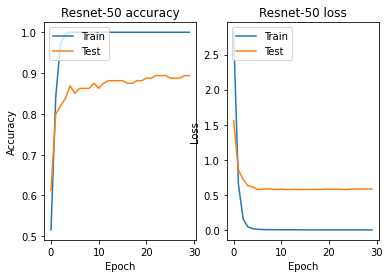

In [47]:
plot_hist(history1,'Resnet-50')

In [48]:
score_train(resnet_model_a,test_x_final_resnet,Y_test)

11/11 [==============================] - 2s 79ms/step - loss: 0.3851 - accuracy: 0.9012
Test loss: 0.3851069509983063
Test accuracy: 0.9011628031730652


Resnet-50-b

In [49]:
resnet_model_b = getResNet50Model(lastFourTrainable=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [50]:
# Train ResNet-50 Model 
#resnet_model_a.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = resnet_model_b.fit(train_x_final_resnet, train_y_final, epochs=30,validation_data=(validation_x_final_resnet, validation_y_final))
#resnet_model_a = trainModelAndGetConfusionMatrix(resnet_model_a,train_x_final,validation_x_final,X_test,10,64)

Epoch 1/30
20/20 [==============================] - 5s 130ms/step - loss: 2.2724 - accuracy: 0.5922 - val_loss: 1.1956 - val_accuracy: 0.7188
Epoch 2/30
20/20 [==============================] - 2s 76ms/step - loss: 0.2854 - accuracy: 0.9359 - val_loss: 0.7341 - val_accuracy: 0.8375
Epoch 3/30
20/20 [==============================] - 2s 83ms/step - loss: 0.0391 - accuracy: 0.9984 - val_loss: 0.6109 - val_accuracy: 0.8875
Epoch 4/30
20/20 [==============================] - 2s 76ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.5375 - val_accuracy: 0.9000
Epoch 5/30
20/20 [==============================] - 1s 74ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.5615 - val_accuracy: 0.8875
Epoch 6/30
20/20 [==============================] - 1s 74ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.5374 - val_accuracy: 0.8938
Epoch 7/30
20/20 [==============================] - 1s 75ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.5476 - val_accuracy: 0.8813
Epoch 8/30
2

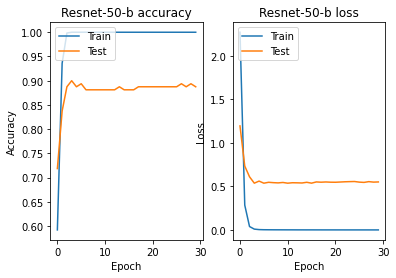

In [51]:
plot_hist(history,'Resnet-50-b')

In [52]:
score_train(resnet_model_b,test_x_final_resnet,Y_test)

11/11 [==============================] - 2s 58ms/step - loss: 0.3810 - accuracy: 0.8924
Test loss: 0.3809841573238373
Test accuracy: 0.8924418687820435


VGG-16-a

In [53]:
train_x_final_vgg16=tensorflow.keras.applications.vgg16.preprocess_input(train_x_final)
validation_x_final_vgg16=tensorflow.keras.applications.vgg16.preprocess_input(validation_x_final)


In [54]:
test_x_final_vgg16=tensorflow.keras.applications.vgg16.preprocess_input(X_test)

In [55]:
vgga=getVGG16Model(lastFourTrainable=False)


553476096/553467096 [==============================] - 7s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [56]:
history = vgga.fit(train_x_final_vgg16, train_y_final,validation_data=(validation_x_final_vgg16,validation_y_final), epochs=30)


Epoch 1/30
20/20 [==============================] - 6s 108ms/step - loss: 3.2090 - accuracy: 0.5531 - val_loss: 1.2736 - val_accuracy: 0.6875
Epoch 2/30
20/20 [==============================] - 2s 99ms/step - loss: 0.3715 - accuracy: 0.9062 - val_loss: 0.8716 - val_accuracy: 0.7937
Epoch 3/30
20/20 [==============================] - 2s 84ms/step - loss: 0.0777 - accuracy: 0.9859 - val_loss: 0.7788 - val_accuracy: 0.7937
Epoch 4/30
20/20 [==============================] - 2s 83ms/step - loss: 0.0169 - accuracy: 0.9953 - val_loss: 0.8137 - val_accuracy: 0.8125
Epoch 5/30
20/20 [==============================] - 2s 100ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.7445 - val_accuracy: 0.8313
Epoch 6/30
20/20 [==============================] - 2s 100ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.7711 - val_accuracy: 0.8375
Epoch 7/30
20/20 [==============================] - 2s 83ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.7582 - val_accuracy: 0.8438
Epoch 8/30

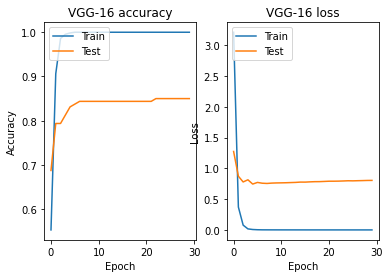

In [57]:
plot_hist(history,'VGG-16')

In [58]:
score_train(vgga,test_x_final_vgg16,Y_test)

11/11 [==============================] - 3s 289ms/step - loss: 0.6356 - accuracy: 0.8605
Test loss: 0.6356416940689087
Test accuracy: 0.8604651093482971


In [59]:
vggb=getVGG16Model(lastFourTrainable=True)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [60]:
history_vgg16_b = vggb.fit(train_x_final_vgg16, train_y_final,validation_data=(validation_x_final_vgg16,validation_y_final), epochs=30)

Epoch 1/30
20/20 [==============================] - 3s 146ms/step - loss: 11.4319 - accuracy: 0.2906 - val_loss: 2.5420 - val_accuracy: 0.4625
Epoch 2/30
20/20 [==============================] - 2s 112ms/step - loss: 2.1002 - accuracy: 0.5219 - val_loss: 2.0743 - val_accuracy: 0.5000
Epoch 3/30
20/20 [==============================] - 2s 95ms/step - loss: 1.5060 - accuracy: 0.6453 - val_loss: 2.0527 - val_accuracy: 0.4938
Epoch 4/30
20/20 [==============================] - 2s 112ms/step - loss: 0.8165 - accuracy: 0.8016 - val_loss: 2.0354 - val_accuracy: 0.5938
Epoch 5/30
20/20 [==============================] - 2s 112ms/step - loss: 0.5689 - accuracy: 0.8625 - val_loss: 1.7597 - val_accuracy: 0.6062
Epoch 6/30
20/20 [==============================] - 2s 112ms/step - loss: 0.2300 - accuracy: 0.9422 - val_loss: 2.5701 - val_accuracy: 0.6750
Epoch 7/30
20/20 [==============================] - 2s 112ms/step - loss: 0.1925 - accuracy: 0.9594 - val_loss: 2.5605 - val_accuracy: 0.6125
Epoch 

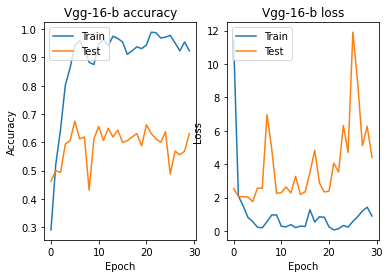

In [61]:
plot_hist(history_vgg16_b,'Vgg-16-b')

In [62]:
score_train(vggb,test_x_final_vgg16,Y_test)

11/11 [==============================] - 1s 68ms/step - loss: 3.7390 - accuracy: 0.6395
Test loss: 3.73898983001709
Test accuracy: 0.6395348906517029


VGG-19-a

In [63]:
train_x_final_vgg19=tensorflow.keras.applications.vgg19.preprocess_input(train_x_final)
validation_x_final_vgg19=tensorflow.keras.applications.vgg19.preprocess_input(validation_x_final)

In [64]:
test_x_final_vgg19=tensorflow.keras.applications.vgg19.preprocess_input(X_test)


In [65]:
history_vgg19_a = vgg_model19_a.fit(train_x_final_vgg19, train_y_final,validation_data=(validation_x_final_vgg19,validation_y_final), epochs=30)

Epoch 1/30
20/20 [==============================] - 3s 122ms/step - loss: 2.9412 - accuracy: 0.5688 - val_loss: 1.3001 - val_accuracy: 0.7000
Epoch 2/30
20/20 [==============================] - 2s 97ms/step - loss: 0.3416 - accuracy: 0.9141 - val_loss: 0.8028 - val_accuracy: 0.8062
Epoch 3/30
20/20 [==============================] - 2s 111ms/step - loss: 0.0505 - accuracy: 0.9937 - val_loss: 0.7844 - val_accuracy: 0.8313
Epoch 4/30
20/20 [==============================] - 2s 98ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.7660 - val_accuracy: 0.8313
Epoch 5/30
20/20 [==============================] - 2s 111ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.7206 - val_accuracy: 0.8562
Epoch 6/30
20/20 [==============================] - 2s 100ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.7290 - val_accuracy: 0.8562
Epoch 7/30
20/20 [==============================] - 2s 111ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.7497 - val_accuracy: 0.8562
Epoch 8/

In [66]:
score_train(vgg_model19_a,test_x_final_vgg19,Y_test)

11/11 [==============================] - 1s 77ms/step - loss: 0.6019 - accuracy: 0.8634
Test loss: 0.6018609404563904
Test accuracy: 0.8633720874786377


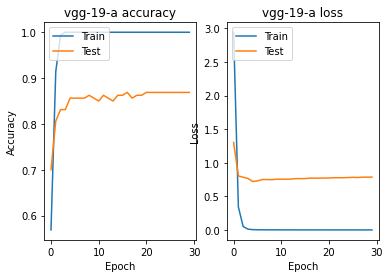

In [67]:
plot_hist(history_vgg19_a,'vgg-19-a')

VGG-19-b

In [68]:
history_vgg19_b = vgg_model19_b.fit(train_x_final_vgg19, train_y_final,validation_data=(validation_x_final_vgg19,validation_y_final), epochs=30)

Epoch 1/30
20/20 [==============================] - 3s 134ms/step - loss: 5.0531 - accuracy: 0.3391 - val_loss: 2.5959 - val_accuracy: 0.4125
Epoch 2/30
20/20 [==============================] - 2s 114ms/step - loss: 2.4134 - accuracy: 0.4547 - val_loss: 2.4362 - val_accuracy: 0.4250
Epoch 3/30
20/20 [==============================] - 2s 125ms/step - loss: 2.1342 - accuracy: 0.4922 - val_loss: 2.3138 - val_accuracy: 0.4625
Epoch 4/30
20/20 [==============================] - 2s 111ms/step - loss: 1.9988 - accuracy: 0.5094 - val_loss: 2.2570 - val_accuracy: 0.4875
Epoch 5/30
20/20 [==============================] - 2s 112ms/step - loss: 1.8792 - accuracy: 0.5469 - val_loss: 2.4482 - val_accuracy: 0.4375
Epoch 6/30
20/20 [==============================] - 2s 125ms/step - loss: 1.8213 - accuracy: 0.5672 - val_loss: 2.8012 - val_accuracy: 0.4375
Epoch 7/30
20/20 [==============================] - 2s 112ms/step - loss: 1.7913 - accuracy: 0.5641 - val_loss: 2.4281 - val_accuracy: 0.4313
Epoch 

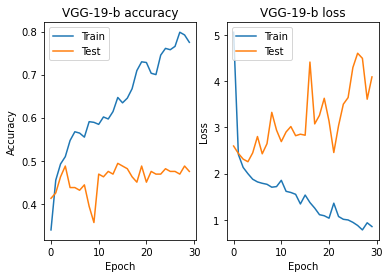

In [69]:
plot_hist(history_vgg19_b,'VGG-19-b')

In [70]:
score_train(vgg_model19_b,test_x_final_vgg19,Y_test)

11/11 [==============================] - 1s 79ms/step - loss: 4.1628 - accuracy: 0.4971
Test loss: 4.162785530090332
Test accuracy: 0.4970930218696594


DenseNet

In [71]:
from keras.applications.densenet import DenseNet121

In [72]:
# Get DenseNet-121 Model
def getDenseNet121Model(lastFourTrainable=False):
    densenet_model = DenseNet121(weights='imagenet', input_shape=input_shape, include_top=True)
    # Make all layers non-trainable
    for layer in densenet_model.layers[:]:
        layer.trainable = False
    # Add fully connected layer which have 1024 neuron to ResNet-50 model
    output = densenet_model.get_layer('avg_pool').output
    output = Flatten(name='new_flatten')(output)
    output = Dense(units=1024, activation='relu', name='new_fc')(output)
    predictions = Dense(units=50, activation='softmax')(output)
    densenet_model = Model(densenet_model.input, predictions)
    # Make last 4 layers trainable if lastFourTrainable == True
    if lastFourTrainable == True:
        densenet_model.get_layer('conv5_block3_2_bn').trainable = True
        densenet_model.get_layer('conv5_block3_3_conv').trainable = True
        densenet_model.get_layer('conv5_block3_3_bn').trainable = True
        densenet_model.get_layer('new_fc').trainable = True
    # Compile ResNet-50 model
    densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    densenet_model.summary()
    return densenet_model

In [73]:
# Get DenseNet-121 Model with lastFourTrainable=False
densenet_model_a = getDenseNet121Model(lastFourTrainable=False)

33202176/33188688 [==============================] - 1s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________

In [74]:
train_x_final_densenet=tensorflow.keras.applications.densenet.preprocess_input(train_x_final)
validation_x_final_densenet=tensorflow.keras.applications.densenet.preprocess_input(validation_x_final)

In [75]:
test_x_final_densenet=tensorflow.keras.applications.densenet.preprocess_input(X_test)

In [76]:
# Train DENSETNET-121 Model 
#resnet_model_a.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history_densenet_model_a = densenet_model_a.fit(train_x_final_densenet, train_y_final, epochs=30,validation_data=(validation_x_final_densenet, validation_y_final))
#resnet_model_a = trainModelAndGetConfusionMatrix(resnet_model_a,train_x_final,validation_x_final,X_test,10,64)

Epoch 1/30
20/20 [==============================] - 9s 164ms/step - loss: 2.1109 - accuracy: 0.5594 - val_loss: 1.4488 - val_accuracy: 0.5813
Epoch 2/30
20/20 [==============================] - 1s 74ms/step - loss: 0.7341 - accuracy: 0.8359 - val_loss: 0.8816 - val_accuracy: 0.8188
Epoch 3/30
20/20 [==============================] - 2s 76ms/step - loss: 0.2798 - accuracy: 0.9594 - val_loss: 0.6790 - val_accuracy: 0.8500
Epoch 4/30
20/20 [==============================] - 1s 74ms/step - loss: 0.1010 - accuracy: 0.9859 - val_loss: 0.5570 - val_accuracy: 0.8813
Epoch 5/30
20/20 [==============================] - 1s 72ms/step - loss: 0.0451 - accuracy: 1.0000 - val_loss: 0.5114 - val_accuracy: 0.8938
Epoch 6/30
20/20 [==============================] - 1s 75ms/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 0.5009 - val_accuracy: 0.9000
Epoch 7/30
20/20 [==============================] - 1s 74ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.4721 - val_accuracy: 0.9062
Epoch 8/30
2

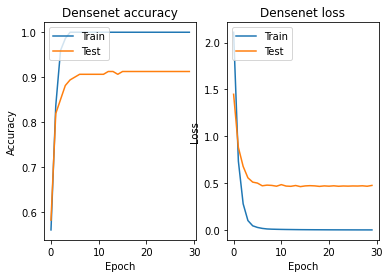

11/11 [==============================] - 3s 98ms/step - loss: 0.3540 - accuracy: 0.9128
Test loss: 0.35401877760887146
Test accuracy: 0.9127907156944275


In [77]:
plot_hist(history_densenet_model_a,'Densenet')
score_train(densenet_model_a,test_x_final_densenet,Y_test)

## KNN- Image Retrieval

Using resnet-50-a for feature extraction and KNN

In [78]:
from keras.models import Model

In [79]:
feature_model_vgg_model19_a= Model(inputs=vgg_model19_a.input, outputs=vgg_model19_a.get_layer('new_fc').output)

In [80]:
feature_vects=feature_model_vgg_model19_a.predict(train_x_final_vgg19)

In [81]:
feature_vects.shape

(640, 1024)

In [82]:
from sklearn.neighbors import KNeighborsClassifier as KNeighborsClassifier

In [83]:
from sklearn.model_selection import GridSearchCV

In [84]:
labels_integers=np.argmax(train_y_final, axis=1)

In [85]:
labels_integers.shape

(640,)

In [86]:
knn = KNeighborsClassifier()
knn.fit(feature_vects,labels_integers)

KNeighborsClassifier()

In [87]:
test_vects=feature_model_vgg_model19_a.predict(test_x_final_vgg19)

In [88]:
test_vects.shape

(344, 1024)

In [89]:
Y_test.shape

(344, 50)

In [90]:
test_label_integers=np.argmax(Y_test, axis=1)

In [91]:
test_label_integers.shape

(344,)

In [92]:
print(knn.score(test_vects,test_label_integers))
#ypred=knn.predict(fin_test_img)

0.8168604651162791


RETREIVAL of FIRST 7 IMAGES

In [93]:
knn7 = KNeighborsClassifier(n_neighbors = 7)
knn7.fit(feature_vects,labels_integers)

KNeighborsClassifier(n_neighbors=7)

In [94]:
indices=knn7.kneighbors(test_vects, return_distance=False)

In [95]:
indices.shape

(344, 7)

In [96]:
np.max(indices)

639

In [97]:
np.min(indices)

1

In [98]:
def show_neighbors(orig, neighbors):
    f, axarr = plt.subplots(4, 2)
    for i, ax in enumerate(axarr.flatten()):
        if i == 0:
            ax.set_title("Query image")
            ax.imshow(orig)
        else:
            ax.set_title(f"Neighbor {i}")
            ax.imshow(train_x_final[neighbors[i-1]])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.tight_layout()
    plt.show()

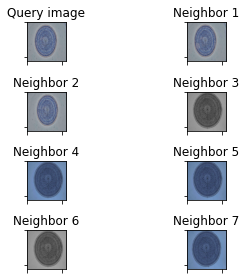

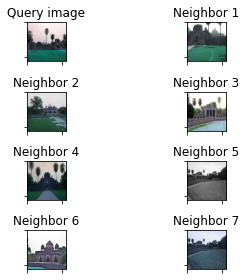

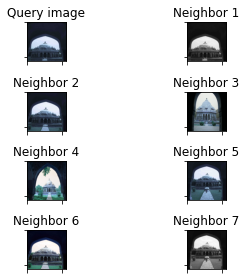

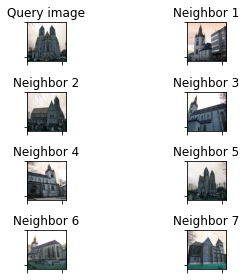

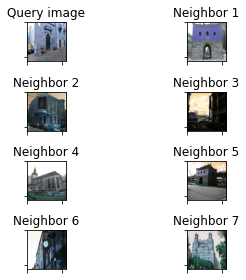

In [99]:
indices=knn7.kneighbors(test_vects, return_distance=False)
for i in range(0,5):
    show_neighbors(X_test[i],indices[i])
    
    

In [100]:
ypred=knn7.predict(test_vects)

In [101]:
from sklearn import metrics 
print(metrics.classification_report(test_label_integers,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       0.75      0.60      0.67         5
           3       0.75      0.67      0.71         9
           4       1.00      1.00      1.00         8
           5       0.00      0.00      0.00         2
           6       0.80      0.80      0.80         5
           7       0.75      0.75      0.75         4
           8       0.75      1.00      0.86         3
           9       0.91      1.00      0.95       148
          10       0.00      0.00      0.00         2
          11       0.50      1.00      0.67         1
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         1
          15       0.33      0.67      0.44         6
          16       1.00      0.86      0.92         7
          17       0.50    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1